In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import cascaded_union

import xarray as xr
import dask
xr.set_options(display_style="html")
import pandas as pd
import numpy as np
import math
from numba import jit
from functools import reduce

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker

import glob
import os
import multiprocessing as mp

import time
import tqdm.notebook as tq

## Neccesary functions

In [142]:
def select_big_from_MP(WS_geometry):
    """
    
    Function return only biggest polygon 
    from multipolygon WS
    It's the real WS, and not malfunctioned part of it
    
    """
    if type(WS_geometry) == MultiPolygon:
        big_area = [polygon_area(lats=polygon.exterior.coords.xy[1],
                                 lons=polygon.exterior.coords.xy[0])
                    for polygon in WS_geometry]
        import numpy as np
        WS_geometry = WS_geometry[np.argmax(big_area)]
    else:
        WS_geometry = WS_geometry
    return WS_geometry


def polygon_area(lats, lons, radius=6378137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats, lons = np.deg2rad(lats), np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0] != lats[-1]:
        lats = append(lats, lats[0])
        lons = append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats) * sin(lons/2)**2
    colat = 2*arctan2(sqrt(a), sqrt(1-a))

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas = diff(colat)/2
    colat = colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate
    area = abs(sum(integrands))/(4*pi)

    area = min(area, 1-area)
    if radius is not None:  # return in units of radius
        return area * 4 * pi * radius**2 / 10**6
    else:  # return in ratio of sphere total area
        return area / 10**6


def find_extent(ws):
    """
    ws - geometry of watershed of interest

    Return list of exterior of watershed by 0.25 degree
    (equal to ERA5 grid)
    """

    def x_round(x):
        return round(x*4)/4

    LONS, LATS = ws.exterior.xy
    max_LAT = max(LATS)
    max_LON = max(LONS)
    min_LAT = min(LATS)
    min_LON = min(LONS)

    return [x_round(min_LON), x_round(max_LON),
            x_round(min_LAT), x_round(max_LAT)]


def create_GDF(shape):
    """
    
    create geodataframe with given shape
    as a geometry
    
    """
    gdf_your_WS = select_big_from_MP(WS_geometry=shape)
    ### WS from your data
    gdf_your_WS = gpd.GeoSeries([gdf_your_WS])

    ### Create extra gdf to use geopandas functions
    gdf_your_WS = gpd.GeoDataFrame({'geometry': gdf_your_WS})
    gdf_your_WS = gdf_your_WS.set_crs('EPSG:4326')

    return gdf_your_WS


def select_NC_by_extent(nc, shape):
    """
    
    select net_cdf by extent of given shape
    
    return masked net_cdf
    
    """
#     if 'time' in nc.dims:
#         nc = nc[0]
#     else:
#         pass

    if 'latitude' in nc.dims:
        nc = nc.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        pass

    # find biggest polygon
    big_shape = select_big_from_MP(WS_geometry=shape)

    # find extent coordinates
    min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=big_shape)

    # select nc inside of extent
    masked_nc = nc.where(
        nc.lat >= min_LAT, drop=True).where(
        nc.lat <= max_LAT, drop=True).where(
        nc.lon >= min_LON, drop=True).where(
        nc.lon <= max_LON, drop=True)
    masked_nc = masked_nc.chunk(chunks='auto')
    return masked_nc


def RotM(alpha):
    """ Rotation Matrix for angle ``alpha`` """
    sa, ca = np.sin(alpha), np.cos(alpha)
    return np.array([[ca, -sa],
                     [sa,  ca]])


def getSquareVertices(mm, h, phi):
    """ Calculate the for vertices for square with center ``mm``,
        side length ``h`` and rotation ``phi`` """
    hh0 = np.ones(2)*h  # initial corner
    vv = [np.asarray(mm) + reduce(np.dot, [RotM(phi), RotM(np.pi/2*c), hh0])
          for c in range(4)]  # rotate initial corner four times by 90°
    return np.asarray(vv)


def ERA_5_time_series_for_WS(ws_ID_row, geometry_row, ERA5_nc, path_to_save):

    variables = list(ERA5_nc.data_vars)

    if len(variables) != 1:
        print('Something went wrong {}'.format(variables))
    else:
        start_time = time.time()
        print('\nVariable {} starts calculation'.format(variables[0]))
        # redefine path_to_save
        path_to_save = path_to_save + variables[0]

        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)

        for ii, test_shape in enumerate(tq.tqdm(geometry_row)):
            # transform selected shape to geodataframe
            # for further manipulations
            big_shape = create_GDF(test_shape)
            # use mask on net_cdf
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                mask_nc = select_NC_by_extent(nc=ERA5_nc[variables[0]],
                                              shape=test_shape)

            # get lat, lon which help define area for intersection
            nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values

            # emulate polygons for ERA5 grid
            polygons = list()
            for j in range(nc_lat.size):
                for i in range(nc_lon.size):
                    # h = 0.125 as a half of ERA5 resolution
                    # phi rotation angle
                    polygons.append(Polygon(getSquareVertices(mm=(nc_lon[i], nc_lat[j]),
                                                              h=0.125,
                                                              phi=0)))
            # create geodataframe from each polygon from emulation
            polygons = [create_GDF(poly) for poly in polygons]
            # find intersection beetween grid cell and actual watershed

            intersected = list()
            for polygon in polygons:
                try:
                    intersected.append(gpd.overlay(df1=big_shape,
                                                   df2=polygon,
                                                   how='intersection'))
                except KeyError:
                    intersected.append(gpd.GeoDataFrame())
            # find biggest intersection if it returns MultiPolygon instance
            # convert to Polygon
            intersected = [select_big_from_MP(section['geometry'][0])
                           if len(section) != 0
                           else gpd.GeoDataFrame()
                           for section in intersected]

            # create mask for intersection with net_cdf
            inter_mask = np.array([section.empty != True
                                   for section in intersected])
            # [1:3] is used because first dimension is time
            inter_mask = inter_mask.reshape(mask_nc.shape[1:3])
            inter_mask = xr.DataArray(data=inter_mask,
                                      dims=['lat', 'lon'],
                                      coords=[nc_lat, nc_lon])
            # create final instersection
            WS_nc = mask_nc.where(inter_mask, drop=True)

            # calculate weights of each intersection correspond to ERA grid cell
            weights = np.array([0 if section.empty
                                else polygon_area(lats=section['geometry'][0].exterior.xy[1],
                                                  lons=section['geometry'][0].exterior.xy[0]) /
                                polygon_area(lats=polygons[i]['geometry'][0].exterior.xy[1],
                                             lons=polygons[i]['geometry'][0].exterior.xy[0])
                                for i, section in enumerate(intersected)])
            # transform to form on NetCDF
            weights = weights.reshape(WS_nc.shape[1:3])
            # transform to DataArray for calculations
            weights = xr.DataArray(data=weights,
                                   dims=['lat', 'lon'])
            weights.name = 'weights'

            if 't2m' in variables:
                # convert to celsius
                WS_nc = WS_nc-273.15
                # apply weighting
                WS_nc = WS_nc * weights
                # record DataFrame
                result_df = pd.DataFrame()
                result_df['date'] = WS_nc.time.values
                result_df[variables[0]] = WS_nc.mean(dim=['lat', 'lon']).values
                if os.path.isfile('{}/{}.csv'.format(path_to_save,
                                                     ws_ID_row.loc[ii])):
                    pass
                else:
                    result_df.to_csv('{}/{}.csv'.format(path_to_save,
                                                        ws_ID_row.loc[ii]),
                                     index=False)
                end_time = time.time()
            else:
                # apply weighting
                WS_nc = WS_nc * weights
                # record DataFrame
                result_df = pd.DataFrame()
                result_df['date'] = WS_nc.time.values
                result_df[variables[0]] = WS_nc.sum(dim=['lat', 'lon']).values
                if os.path.isfile('{}/{}.csv'.format(path_to_save,
                                                     ws_ID_row.loc[ii])):
                    pass
                else:
                    result_df.to_csv('{}/{}.csv'.format(path_to_save,
                                                        ws_ID_row.loc[ii]),
                                     index=False)
                end_time = time.time()
        print("Variable {} successfully calculated in {:.2f} minutes".format(variables[0],
                                                                             (end_time - start_time) / 60))

        return


In [145]:
conus_bains_path = "/home/dima/Documents/education/HSI/aspirantura/Dissertation/conus_data/basin_set_full_res/HCDN_nhru_final_671.shp"
CONUS_WS = gpd.read_file(conus_bains_path)
# select only biggest polygon from mulitipolygons file
# if any exists
CONUS_WS['geometry'] = [select_big_from_MP(ws) 
                         for ws in CONUS_WS['geometry']]

In [146]:
data_paths = ('/media/dima/kek1/ERA5_data/CONUS/daily/2m_temperature/*.nc')

data_paths_max = [i
                  for i in glob.glob(data_paths)
                  if i.split('/')[-1].split('_')[1] == 'max']

data_paths_min = [i
                  for i in glob.glob(data_paths)
                  if i.split('/')[-1].split('_')[1] == 'min']

data_paths = [i
              for i in glob.glob(data_paths)
              if len(i.split('/')[-1].split('_')[1]) != 3]

compile_set = {'max_t2m': data_paths_max,
               'min_t2m': data_paths_min,
               't2m': data_paths}


In [159]:
xr.open_dataset('/media/dima/kek1/ERA5_data/CONUS/daily/2m_temperature/t2m_max_1957.nc')['t2m'][0][0][0].values

array(272.7621, dtype=float32)

In [158]:
xr.open_dataset('/media/dima/kek1/ERA5_data/CONUS/daily/2m_temperature/t2m_1957.nc')['t2m'][0][0][0].values

array(272.7621, dtype=float32)

In [154]:
nc_data['t2m'][0][0][0].values

array(254.55176, dtype=float32)

In [147]:
for key, pathes in compile_set.items():
    print(f'Расчёт для {key}\n')
    
    nc_data = xr.open_mfdataset(paths=pathes,
                                engine='netcdf4',
                                chunks='auto')
    
    ERA_5_time_series_for_WS(ws_ID_row=CONUS_WS['hru_id'],
                             geometry_row=CONUS_WS['geometry'],
                             ERA5_nc=nc_data,
                             path_to_save=f'/home/dima/Documents/education/HSI/aspirantura/Dissertation/conus_data/WS_by_VARIABLE/{key}')

Расчёт для max_t2m


Variable t2m starts calculation


  0%|          | 0/671 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print('\nCalculation for {} files'.format(var_names[i]))
nc_data = xr.open_mfdataset(paths=data_paths,
                            engine='netcdf4',
                            chunks='auto')
ERA_5_time_series_for_WS(ws_ID_row=CONUS_WS['hru_id'],
                         geometry_row=CONUS_WS['geometry'],
                         ERA5_nc=nc_data,
                         path_to_save='/home/dima/Documents/education/HSI/aspirantura/Dissertation/conus_data/WS_by_VARIABLE_t2m/')

In [44]:
test_shape = CONUS_WS.loc[0, 'geometry']

variables = list(nc_data.data_vars)

In [118]:
big_shape = create_GDF(test_shape)
# use mask on net_cdf
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    mask_nc = select_NC_by_extent(nc=nc_data[variables[0]],
                                    shape=test_shape);

# get lat, lon which help define area for intersection
nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values

# emulate polygons for ERA5 grid
polygons = list()
for j in range(nc_lat.size):
    for i in range(nc_lon.size):
        # h = 0.125 as a half of ERA5 resolution
        # phi rotation angle
        polygons.append(Polygon(getSquareVertices(mm=(nc_lon[i], nc_lat[j]),
                                                    h=0.125,
                                                    phi=0)))
# create geodataframe from each polygon from emulation
polygons = list(map(create_GDF, polygons))
# polygons = [create_GDF(poly) for poly in polygons]
# find intersection beetween grid cell and actual watershed
intersection = list()
for polygon in polygons:
    try:
        intersection.append(gpd.overlay(df1=big_shape,
                                        df2=polygon,
                                        how='intersection'))
    except KeyError:
        intersection.append(gpd.GeoDataFrame())

intersection = [select_big_from_MP(section['geometry'][0]) if len(section) != 0
                else gpd.GeoDataFrame() 
                for section in intersection]

        
# [gpd.overlay(df1=big_shape, 
#                 df2=poly,
#                 how='intersection') 
#     for poly in polygons]

In [135]:
inter_mask = np.array([section.empty != True for section in intersection])

In [137]:
inter_mask = inter_mask.reshape(mask_nc.shape[1:3])
inter_mask = xr.DataArray(data=inter_mask,
                            dims=['lat', 'lon'],
                            coords=[nc_lat, nc_lon])

In [139]:
# create final instersection
WS_nc = mask_nc.where(inter_mask, drop=True)

In [140]:
WS_nc

<xarray.DataArray 't2m' (time: 25933, lat: 3, lon: 5)>
dask.array<where, shape=(25933, 3, 5), dtype=float32, chunksize=(25933, 3, 5), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -69.0 -68.75 -68.5 -68.25 -68.0
  * lat      (lat) float64 47.25 47.0 46.75
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31

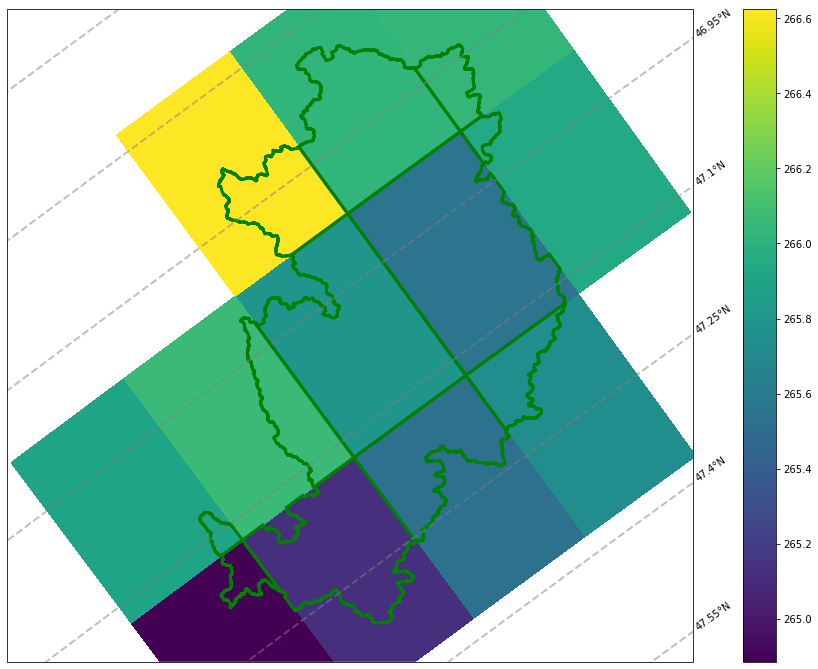

In [141]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                              standard_parallels=(50, 70),
                              central_latitude=56,
                              false_easting=0,
                              false_northing=0)

merc_crs = ccrs.Mercator()


fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=aea_crs)

min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=CONUS_WS['geometry'][0:1][0])
# W, E, S, N
ax.set_extent([min_LON, max_LON, min_LAT, max_LAT],
              crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])

fig = plt.pcolor(WS_nc['lon'], WS_nc['lat'], WS_nc[0], 
                 shading='auto',
                 transform=ccrs.PlateCarree())

plt.colorbar(fig)

# ax.add_geometries(big_shape['geometry'],
#                   crs=ccrs.PlateCarree(),
#                   facecolor="None",
#                   edgecolor='red',
#                   linewidth=3)

ax.add_geometries([inter for inter in intersection if type(inter) == Polygon],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='green',
                  linewidth=3)

ax.patch.set_alpha(0)

plt.show();


Calculation for 2m_temperature files

Variable t2m starts calculation


  0%|          | 0/671 [00:00<?, ?it/s]

KeyError: "['__idx1' '__idx2'] not found in axis"

#### Temperature -- Kelvin
#### Evaporation -- m of water equivalent
#### Potential Evaporation -- m
#### Runoff -- m
#### Total Precipitation -- m

In [ ]:
# temp_data = xr.open_mfdataset('/mnt/f/ERA5_data/CONUS/daily/2m_temperature/*.nc',
#                               chunks='auto');
# evap_data = xr.open_mfdataset('/mnt/f/ERA5_data/CONUS/daily/evaporation/*.nc',
#                               chunks='auto');
# pevap_data = xr.open_mfdataset('/mnt/f/ERA5_data/CONUS/daily/potential_evaporation/*.nc',
#                               chunks='auto');
# runoff_data = xr.open_mfdataset('/mnt/f/ERA5_data/CONUS/daily/runoff/*.nc',
#                               chunks='auto');
# precip_data = xr.open_mfdataset('/mnt/f/ERA5_data/CONUS/daily/total_precipitation/*.nc',
#                               chunks='auto');

In [ ]:
['t2m', 'e', 'pev', 'ro', 'tp']

['t2m', 'e', 'pev', 'ro', 'tp']

## Read watersheds from CONUS data 

In [ ]:
conus_bains_path = "/home/dima/Documents/education/HSI/aspirantura/Dissertation/conus_data/basin_set_full_res/HCDN_nhru_final_671.shp"
CONUS_WS = gpd.read_file(conus_bains_path)
# select only biggest polygon from mulitipolygons file
# if any exists
CONUS_WS['geometry'] = [select_big_from_MP(ws) 
                         for ws in CONUS_WS['geometry']]

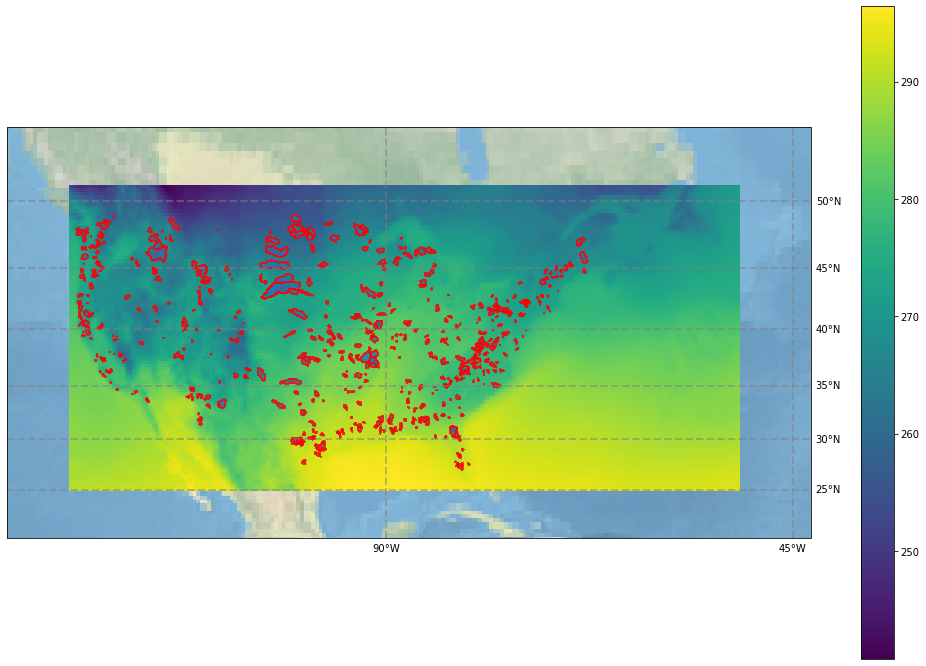

In [ ]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                               standard_parallels=(50, 70),
                               central_latitude=56,
                               false_easting=0,
                               false_northing=0)

merc_crs = ccrs.Mercator()


fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=merc_crs)


ax.stock_img()
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)
# E W S N
# Russia
# [30, 169, 38, 85]
# CONUS
# [-132, -43, 20, 65]
extent = [-132, -43, 20, 55]
ax.set_extent(extent,
              crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-180, -135, -90, -45, 0, 45, 90, 135, 180])


fig = plt.pcolor(temp_data['t2m'][0].longitude, temp_data['t2m'][0].latitude,
                 temp_data['t2m'][0], transform=ccrs.PlateCarree(), 
                 shading='auto')

plt.colorbar(fig)

ax.add_geometries(CONUS_WS['geometry'].to_numpy(),
                  crs=ccrs.PlateCarree(),
                  edgecolor='red', 
                  alpha=0.8);

## Read test file from folder with daily data for ERA Interim

### Loop through watersheds and calculate time series for each watershed with given characteristics

In [ ]:
data_paths

'/media/dima/kek1/ERA5_data/CONUS/daily/2m_temperature/*.nc'

In [ ]:
# get variables for computation
var_names = [i.split('/')[-1] 
             for i in 
             glob.glob('/media/dima/kek1/ERA5_data/CONUS/daily/*')]
# define paths
# data_paths = ('/mnt/f/ERA5_data/CONUS/daily/2m_temperature/*.nc', 
#               '/mnt/f/ERA5_data/CONUS/daily/evaporation/*.nc',
#               '/mnt/f/ERA5_data/CONUS/daily/potential_evaporation/*.nc',
#               '/mnt/f/ERA5_data/CONUS/daily/runoff/*.nc',
#               '/mnt/f/ERA5_data/CONUS/daily/total_precipitation/*.nc')
data_paths = ('/media/dima/kek1/ERA5_data/CONUS/daily/2m_temperature/*.nc')

for i, path in enumerate(data_paths):
    print('\nCalculation for {} files'.format(var_names[i]))
    nc_data = xr.open_mfdataset(paths=path,
                                engine='netcdf4',
                                chunks='auto')
    ERA_5_time_series_for_WS(ws_ID_row=CONUS_WS['hru_id'],
                             geometry_row=CONUS_WS['geometry'],
                             ERA5_nc=nc_data,
                             path_to_save='/home/dima/Documents/education/HSI/aspirantura/Dissertation/conus_data/WS_by_VARIABLE_t2m/')

#### geometry_row == CONUS_WS['geometry']
#### ERA5_nc == temp_data

## Unlucky

In [ ]:
%%time
def parallelize_function(WS_id, WS_geom, NC, path_to_save):
    
    """
    This function generate list of tuples
    where each tuple stands for row in DF
    of watersheds
    
    WS_id -- id of watershed which will be used as file save name
    WS_geom -- geometry of watershed
    NC -- net_cdf file 
    path_to_save -- path where files will be saved
    """
    mp_tuples = list()
    for row in range(len(WS_id)):
        mp_tuples.append((WS_id[row],
                          WS_geom[row],
                          NC,
                          path_to_save))
    
    return mp_tuples

# WS_id, WS_geom, NC, path_to_save
data = parallelize_function(WS_id=CONUS_WS['hru_id'],
                            WS_geom=CONUS_WS['geometry'],
                            NC=temp_data,
                            path_to_save='/mnt/e/education/HSI/aspirantura/Dissertation/conus_data/WS_by_VARIABLE/')

# get count of cpu. Substract by 2 to not to overwhelm system
function_processors = mp.cpu_count()//2
process_pool = mp.Pool(function_processors)

# WS_id, WS_geom, NC, path_to_save
output = process_pool.starmap(ERA_5_time_series_for_WS, tq.tqdm(data))
process_pool.close()
process_pool.join()

In [ ]:
# selectvalueslest shape in CONUS
test_shape = CONUS_WS.sort_values(by='AREA',
                                  ascending=True).iloc[0]['geometry']
# transform to geodataframe
big_shape = create_GDF(test_shape)

# use mask on net_cdf
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    mask_nc = select_NC_by_extent(nc=E, shape=test_shape);

######################################################
nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values
######################################################
polygons = list()
for j in range(nc_lat.size):
    for i in range(nc_lon.size):
        # h = 0.125 as a half of ERA5 resolution
        # phi rotation angle
        polygons.append(Polygon(getSquareVertices(mm=(nc_lon[i], nc_lat[j]),
                                                  h=0.125,
                                                  phi=0)))
# create geodataframe from each polygon from 
polygons = [create_GDF(poly) for poly in polygons]

intersected = [gpd.overlay(df1=big_shape, 
                           df2=poly, how='intersection') 
               for poly in polygons]

# find biggest intersection if it returns MultiPolygon instance
for i, section in enumerate(intersected):
    if section.empty:
        pass
    else:
        section['geometry'] = select_big_from_MP(section['geometry'][0])
        
# create mask for intersection with net_cdf
inter_mask = np.array([section.empty == False for section in intersected])
inter_mask = inter_mask.reshape(mask_nc.shape[1:3])
inter_mask = xr.DataArray(data=inter_mask,
                          dims=['lat', 'lon'],
                          coords=[nc_lat, nc_lon])
# create final instersection
WS_nc = mask_nc.where(inter_mask, drop=True)

# calculate weights of each intersection correspond to ERA grid cell
weights = [0 if section.empty
           else polygon_area(lats=section['geometry'][0].exterior.xy[1],
                             lons=section['geometry'][0].exterior.xy[0])/
           polygon_area(lats=polygons[i]['geometry'][0].exterior.xy[1],
                        lons=polygons[i]['geometry'][0].exterior.xy[0]) 
           for i, section in enumerate(intersected)]
######################################################
result_df = pd.DataFrame()
result_df['date']=WS_nc.time.values
result_df['t2m']=WS_nc.mean(dim=['lat', 'lon']).values

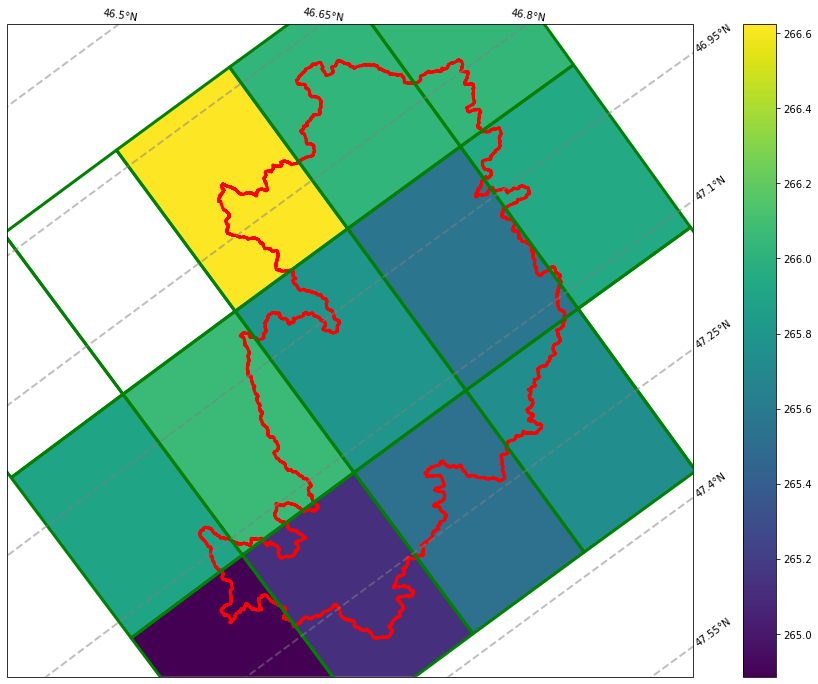

In [ ]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                              standard_parallels=(50, 70),
                              central_latitude=56,
                              false_easting=0,
                              false_northing=0)

merc_crs = ccrs.Mercator()


fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=aea_crs)

min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=CONUS_WS['geometry'][0:1][0])
# W, E, S, N
ax.set_extent([min_LON, max_LON, min_LAT, max_LAT],
              crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])


fig = plt.pcolor(test_Nc['lon'], test_Nc['lat'], test_Nc[0], 
                 shading='auto',
                 transform=ccrs.PlateCarree())

plt.colorbar(fig)

ax.add_geometries([CONUS_WS['geometry'][0:1][0]],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='red',
                  linewidth=3)

ax.add_geometries([poly['geometry'][0] for poly in polygons],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='green',
                  linewidth=3)

ax.patch.set_alpha(0)

plt.show();